In [3]:
# Import required packages
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from skimage.io import imread
from skimage.transform import resize
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import random
from sklearn.metrics import f1_score, precision_score, recall_score
import torch.nn as nn
import torch.nn.init as init

In [2]:
# Import image data, including flattening the images and converting them to an array
    # (Without masks)
#normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
#covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
#images = []
#labels = []
#for image in os.listdir(normal_folder_path):
#    image_path = os.path.join(normal_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(0)
#for image in os.listdir(covid_folder_path):
#    image_path = os.path.join(covid_folder_path, image)
#    i = mpimg.imread(image_path)
#    #i = resize(i, (299,299))
#    flati = i.flatten()
#    images.append(flati)
#    labels.append(1)
#X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [3]:
# Import image data, including flattening the images and converting them to an array
    # (With masks)
normal_folder_path = 'COVID-19_Radiography_Dataset/Normal/images'
normal_mask_path = 'COVID-19_Radiography_Dataset/Normal/masks'
covid_folder_path = 'COVID-19_Radiography_Dataset/COVID/images'
covid_mask_path = 'COVID-19_Radiography_Dataset/COVID/masks'
images = []
labels = []
for image in os.listdir(normal_folder_path):
    image_path = os.path.join(normal_folder_path, image)
    mask_path = os.path.join(normal_mask_path, image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(0)
for image in os.listdir(covid_folder_path):
    image_path = os.path.join(covid_folder_path, image)
    mask_path = os.path.join(covid_mask_path,image)
    i = mpimg.imread(image_path)
    i = resize(i, (256,256))
    mask = mpimg.imread(mask_path)
    mask = mask[:,:,0]
    i = i*mask
    flati = i.flatten()
    images.append(flati)
    labels.append(1)
X , y = np.array(images, dtype = 'float32'), np.array(labels, dtype = 'int')[:,np.newaxis]

In [4]:
# Split the data into test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2024) # test set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.18, random_state=2024) # validation set

In [5]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [6]:
# Create PCA sets for reduced dimension models
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

In [7]:
# Convert to tensors for PyTorch training
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype = torch.float32)
y_val_tensor = torch.tensor(y_val ,dtype = torch.float32)

X_train_tensor_pca = torch.tensor(X_train_pca, dtype = torch.float32)
X_test_tensor_pca = torch.tensor(X_test_pca, dtype = torch.float32)
X_val_tensor_pca = torch.tensor(X_val_pca, dtype = torch.float32)

In [8]:
# Define a direct MLP model
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class DirectMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 512),
            nn.ReLU(),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class DropoutMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65536, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

class PCA_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
    
class PCA_ExtraParam_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)   

In [9]:
# Create function to test each model
def test_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            # Forward pass: compute predictions
            outputs = model(inputs)
            
            # Since our output is a single probability (binary classification), 
            # apply threshold to classify
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            
            # Collect predictions and labels for F1-score
            all_labels.extend(labels.cpu().numpy())  # Convert to numpy for compatibility
            all_predictions.extend(predicted.cpu().numpy())
            
            # Update totals
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate accuracy
    accuracy = correct / total
    
    # Calculate precision, recall, and F1
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return accuracy, precision, recall, f1

In [10]:
test_dataset = TensorDataset(X_test_scaled_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

**Train Logistic Regression Model**

In [11]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
LR_model = LogisticRegression()
optimizer = torch.optim.Adam(LR_model.parameters(), lr=0.001)
num_epochs = 500

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    LR_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = LR_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    LR_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = LR_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/500], Train Loss: 4.3374, Val Loss: 4.7574
Epoch [2/500], Train Loss: 3.8881, Val Loss: 4.6903
Epoch [3/500], Train Loss: 3.3547, Val Loss: 4.5535
Epoch [4/500], Train Loss: 3.4437, Val Loss: 4.1096
Epoch [5/500], Train Loss: 2.8448, Val Loss: 4.6727
Patience Counter: 1/10
Epoch [6/500], Train Loss: 2.6708, Val Loss: 4.5747
Patience Counter: 2/10
Epoch [7/500], Train Loss: 2.3563, Val Loss: 4.2622
Patience Counter: 3/10
Epoch [8/500], Train Loss: 2.1364, Val Loss: 4.7816
Patience Counter: 4/10
Epoch [9/500], Train Loss: 1.9707, Val Loss: 4.5013
Patience Counter: 5/10
Epoch [10/500], Train Loss: 1.9691, Val Loss: 3.9950
Epoch [11/500], Train Loss: 2.0713, Val Loss: 4.6801
Patience Counter: 1/10
Epoch [12/500], Train Loss: 1.6568, Val Loss: 4.4478
Patience Counter: 2/10
Epoch [13/500], Train Loss: 1.7933, Val Loss: 5.0460
Patience Counter: 3/10
Epoch [14/500], Train Loss: 1.7409, Val Loss: 4.6930
Patience Counter: 4/10
Epoch [15/500], Train Loss: 1.6707, Val Loss: 4.9965
Patienc

Text(0.5, 1.0, 'Training and Validation Accuracy')

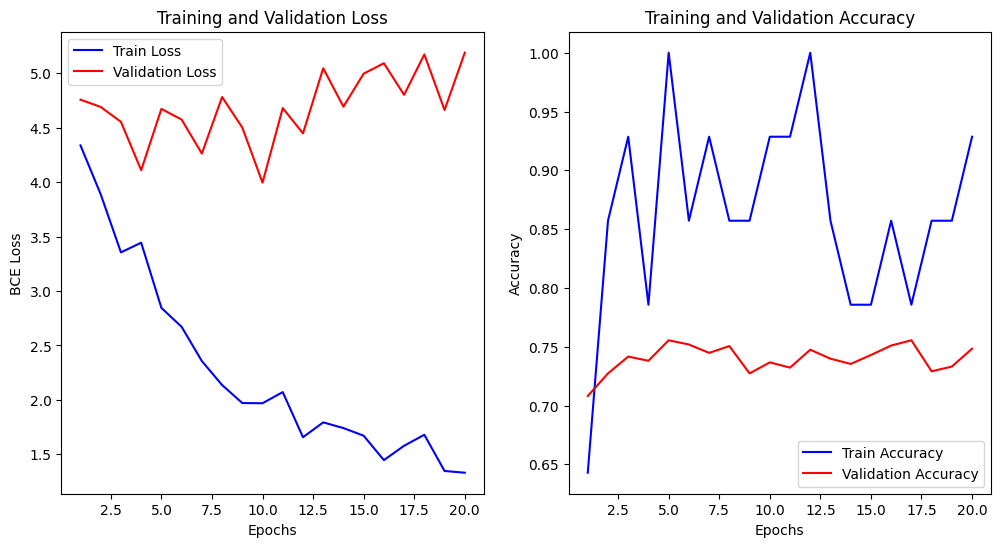

In [12]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [13]:
LR_train_evaluation = test_model(LR_model,train_dataloader)
LR_val_evaluation = test_model(LR_model,val_dataloader)
LR_test_evaluation = test_model(LR_model,test_dataloader)
LR_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": LR_train_evaluation,
    "Validation": LR_val_evaluation,
    "Test": LR_test_evaluation,
}
LR_evaluation = pd.DataFrame(LR_evaluation)
LR_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.939843,0.748324,0.755250
1,Precision,0.876593,0.520868,0.510695
2,Recall,0.897837,0.530612,0.552023
3,F1-Score,0.887088,0.525695,0.530556


**Train MLP Model**

In [14]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Early stopping parameters
patience = 3  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
MLP_model = DirectMLP()
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
num_epochs = 80

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    MLP_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = MLP_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    MLP_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = MLP_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/80], Train Loss: 10.3040, Val Loss: 5.8225
Epoch [2/80], Train Loss: 3.1930, Val Loss: 3.7727
Epoch [3/80], Train Loss: 2.5850, Val Loss: 1.8711
Epoch [4/80], Train Loss: 2.5194, Val Loss: 2.2915
Patience Counter: 1/3
Epoch [5/80], Train Loss: 1.8035, Val Loss: 2.3827
Patience Counter: 2/3
Epoch [6/80], Train Loss: 1.6132, Val Loss: 1.6630
Epoch [7/80], Train Loss: 1.2328, Val Loss: 1.6851
Patience Counter: 1/3
Epoch [8/80], Train Loss: 1.1737, Val Loss: 1.9619
Patience Counter: 2/3
Epoch [9/80], Train Loss: 1.1040, Val Loss: 1.7013
Patience Counter: 3/3
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

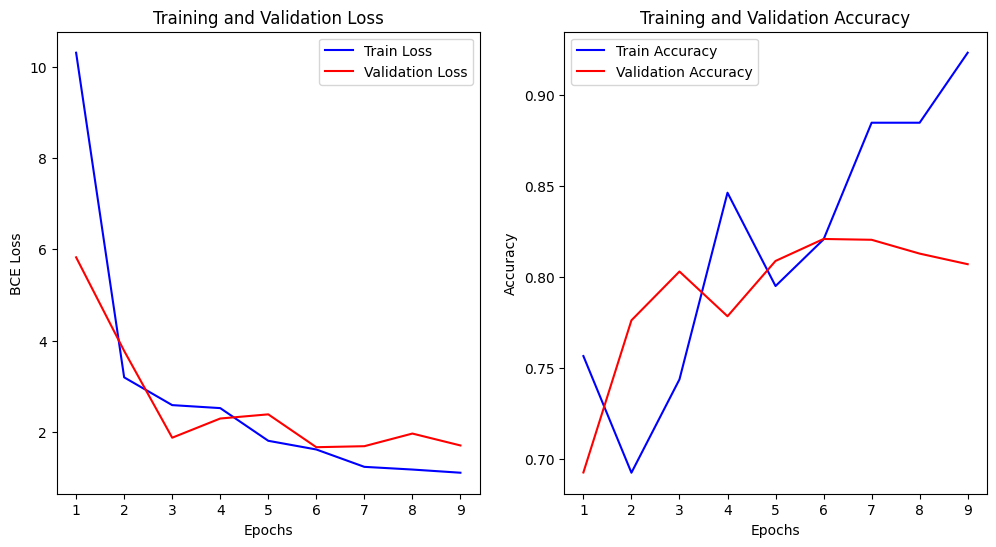

In [15]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [16]:
MLP_train_evaluation = test_model(MLP_model,train_dataloader)
MLP_val_evaluation = test_model(MLP_model,val_dataloader)
MLP_test_evaluation = test_model(MLP_model,test_dataloader)
MLP_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": MLP_train_evaluation,
    "Validation": MLP_val_evaluation,
    "Test": MLP_test_evaluation,
}
MLP_evaluation = pd.DataFrame(MLP_evaluation)
MLP_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.936114,0.806884,0.824765
1,Precision,0.930844,0.665254,0.679310
2,Recall,0.818046,0.534014,0.569364
3,F1-Score,0.870808,0.592453,0.619497


**Train Dropout Model**

In [17]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_scaled_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = TensorDataset(X_val_scaled_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
Dropout_model = DropoutMLP()
optimizer = torch.optim.Adam(Dropout_model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    Dropout_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = Dropout_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    Dropout_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = Dropout_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/50], Train Loss: 0.6713, Val Loss: 0.4964
Epoch [2/50], Train Loss: 0.5001, Val Loss: 0.4570
Epoch [3/50], Train Loss: 0.4535, Val Loss: 0.4297
Epoch [4/50], Train Loss: 0.4199, Val Loss: 0.4037
Epoch [5/50], Train Loss: 0.4021, Val Loss: 0.3973
Epoch [6/50], Train Loss: 0.3921, Val Loss: 0.3810
Epoch [7/50], Train Loss: 0.3613, Val Loss: 0.3872
Patience Counter: 1/5
Epoch [8/50], Train Loss: 0.3417, Val Loss: 0.3785
Epoch [9/50], Train Loss: 0.3295, Val Loss: 0.3683
Epoch [10/50], Train Loss: 0.3065, Val Loss: 0.3729
Patience Counter: 1/5
Epoch [11/50], Train Loss: 0.2977, Val Loss: 0.3731
Patience Counter: 2/5
Epoch [12/50], Train Loss: 0.2799, Val Loss: 0.4038
Patience Counter: 3/5
Epoch [13/50], Train Loss: 0.2669, Val Loss: 0.4093
Patience Counter: 4/5
Epoch [14/50], Train Loss: 0.2529, Val Loss: 0.4413
Patience Counter: 5/5
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

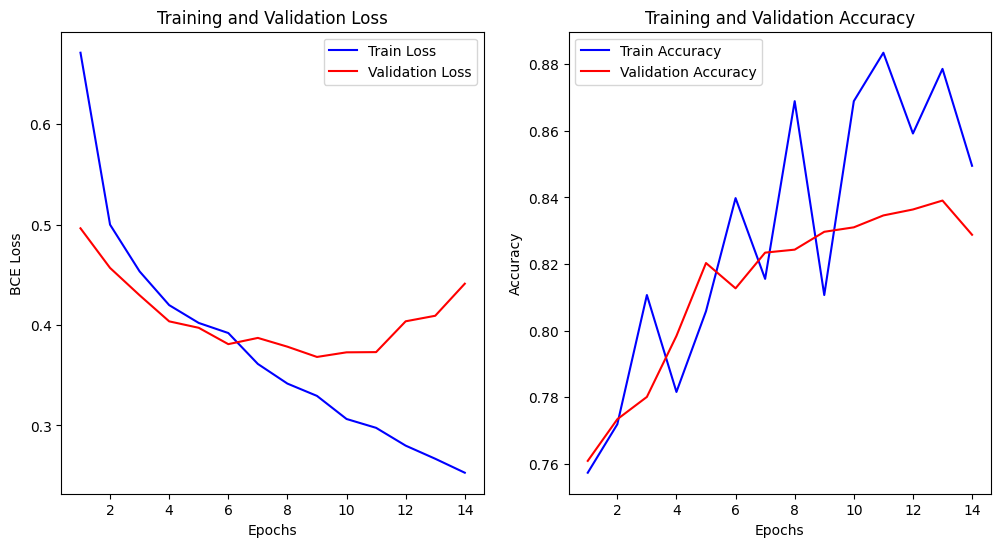

In [18]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [19]:
Dropout_train_evaluation = test_model(Dropout_model,train_dataloader)
Dropout_val_evaluation = test_model(Dropout_model,val_dataloader)
Dropout_test_evaluation = test_model(Dropout_model,test_dataloader)
Dropout_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": Dropout_train_evaluation,
    "Validation": Dropout_val_evaluation,
    "Test": Dropout_test_evaluation,
}
Dropout_evaluation = pd.DataFrame(Dropout_evaluation)
Dropout_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.911482,0.828789,0.828385
1,Precision,0.934146,0.740047,0.728033
2,Recall,0.714019,0.537415,0.502890
3,F1-Score,0.809383,0.622660,0.594872


**Train PCA Reduced Model**

In [20]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCA_model = PCA_MLP()
optimizer = torch.optim.Adam(PCA_model.parameters(), lr=0.001)
num_epochs = 150

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCA_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCA_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCA_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCA_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/150], Train Loss: 0.5314, Val Loss: 0.4769
Epoch [2/150], Train Loss: 0.3182, Val Loss: 0.4624
Epoch [3/150], Train Loss: 0.2495, Val Loss: 0.5060
Patience Counter: 1/10
Epoch [4/150], Train Loss: 0.1964, Val Loss: 0.5268
Patience Counter: 2/10
Epoch [5/150], Train Loss: 0.1541, Val Loss: 0.5540
Patience Counter: 3/10
Epoch [6/150], Train Loss: 0.1157, Val Loss: 0.5873
Patience Counter: 4/10
Epoch [7/150], Train Loss: 0.0839, Val Loss: 0.6769
Patience Counter: 5/10
Epoch [8/150], Train Loss: 0.0643, Val Loss: 0.7358
Patience Counter: 6/10
Epoch [9/150], Train Loss: 0.0599, Val Loss: 0.7924
Patience Counter: 7/10
Epoch [10/150], Train Loss: 0.0504, Val Loss: 0.7994
Patience Counter: 8/10
Epoch [11/150], Train Loss: 0.0471, Val Loss: 1.0530
Patience Counter: 9/10
Epoch [12/150], Train Loss: 0.0354, Val Loss: 1.1337
Patience Counter: 10/10
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

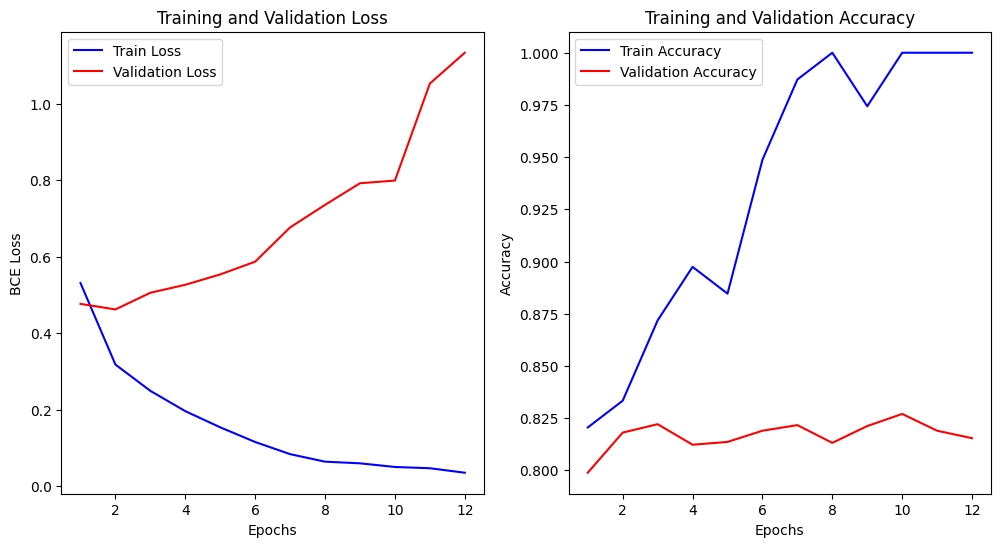

In [21]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [22]:
test_dataset = TensorDataset(X_test_tensor_pca, y_test_tensor)
test_dataloader = DataLoader(test_dataset)

In [23]:
PCA_train_evaluation = test_model(PCA_model,train_dataloader)
PCA_val_evaluation = test_model(PCA_model,val_dataloader)
PCA_test_evaluation = test_model(PCA_model,test_dataloader)
PCA_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCA_train_evaluation,
    "Validation": PCA_val_evaluation,
    "Test": PCA_test_evaluation,
}
PCA_evaluation = pd.DataFrame(PCA_evaluation)
PCA_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.996663,0.815378,0.812455
1,Precision,0.991463,0.666667,0.632219
2,Recall,0.995899,0.595238,0.601156
3,F1-Score,0.993676,0.628931,0.616296


**Train PCA Model with Extra Parameters**

In [24]:
# Prepare training and validation sets
train_dataset = TensorDataset(X_train_tensor_pca, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor_pca, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Early stopping parameters
patience = 8  # Number of epochs to wait before stopping if no improvement
min_delta = 1e-4  # Minimum change in validation loss to qualify as an improvement
best_val_loss = 999999  # Best validation loss observed
patience_counter = 0  # Counter for early stopping

loss_function = nn.BCELoss()
PCAX_model = PCA_ExtraParam_MLP()
optimizer = torch.optim.Adam(PCAX_model.parameters(), lr=0.001)
num_epochs = 75

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    PCAX_model.train()
    
    batch_count = 0
    counter = 0
    epoch_loss = 0
    
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = PCAX_model(inputs)
        
        # Calculate the loss
        loss = loss_function(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        counter += 1
        #print(counter)
        
        epoch_loss += loss.item()
        batch_count += 1
        
        predicted_train = (outputs > 0.5).float()
        correct_train = (predicted_train == labels).sum().item()
        total_train = labels.size(0)
        
    train_losses.append(epoch_loss/batch_count)
    train_accuracies.append(correct_train/total_train)
    
    # Validation loop
    PCAX_model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = PCAX_model(inputs)
            
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    
    # Average validation loss
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
        
    # Print the loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping logic
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

Epoch [1/75], Train Loss: 0.4374, Val Loss: 0.3908
Epoch [2/75], Train Loss: 0.3108, Val Loss: 0.4080
Patience Counter: 1/8
Epoch [3/75], Train Loss: 0.2284, Val Loss: 0.4579
Patience Counter: 2/8
Epoch [4/75], Train Loss: 0.1727, Val Loss: 0.5477
Patience Counter: 3/8
Epoch [5/75], Train Loss: 0.1283, Val Loss: 0.5701
Patience Counter: 4/8
Epoch [6/75], Train Loss: 0.0976, Val Loss: 0.8632
Patience Counter: 5/8
Epoch [7/75], Train Loss: 0.0683, Val Loss: 0.7297
Patience Counter: 6/8
Epoch [8/75], Train Loss: 0.0559, Val Loss: 0.9147
Patience Counter: 7/8
Epoch [9/75], Train Loss: 0.0394, Val Loss: 1.0678
Patience Counter: 8/8
Early stopping triggered!


Text(0.5, 1.0, 'Training and Validation Accuracy')

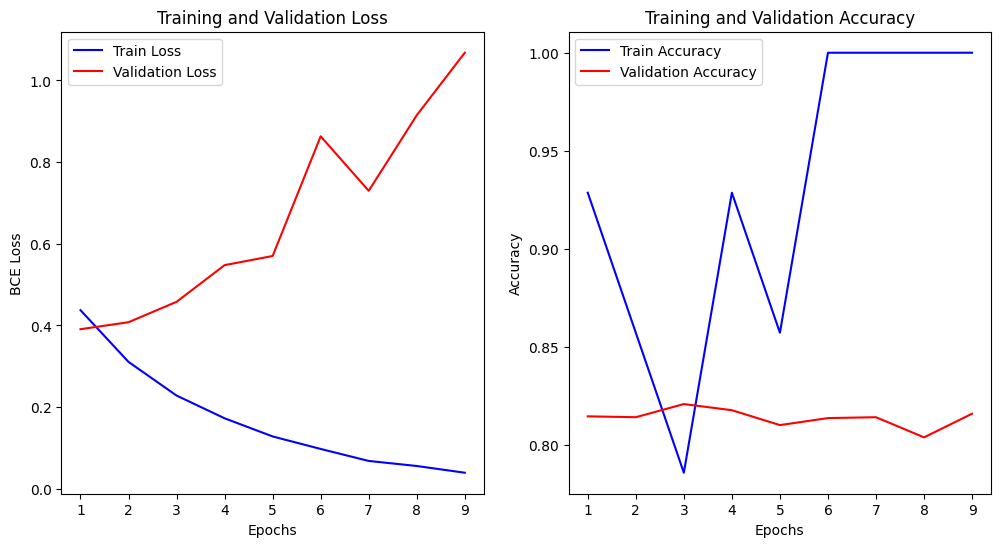

In [25]:
# Graph the error on each batch in the epoch I trained
graph_param = len(train_losses)+1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, graph_param),train_losses,color = 'blue',label = 'Train Loss')
plt.plot(range(1, graph_param),val_losses,color = 'red', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, graph_param),train_accuracies,color = 'blue', label = 'Train Accuracy')
plt.plot(range(1, graph_param),val_accuracies,color = 'red', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [26]:
PCAX_train_evaluation = test_model(PCA_model,train_dataloader)
PCAX_val_evaluation = test_model(PCA_model,val_dataloader)
PCAX_test_evaluation = test_model(PCA_model,test_dataloader)
PCAX_evaluation = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1-Score"],
    "Train": PCAX_train_evaluation,
    "Validation": PCAX_val_evaluation,
    "Test": PCAX_test_evaluation,
}
PCAX_evaluation = pd.DataFrame(PCAX_evaluation)
PCAX_evaluation

,Metric,Train,Validation,Test
0,Accuracy,0.996663,0.815378,0.812455
1,Precision,0.991463,0.666667,0.632219
2,Recall,0.995899,0.595238,0.601156
3,F1-Score,0.993676,0.628931,0.616296


Part 2

### IMPORTS

In [7]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import numpy as np
from kagglehub import dataset_download


/home/smg0092/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocess DataSet

In [8]:
### HELPER FUNCTIONS
def get_subdirectories(folder_path):
    subdirectory_path_list = []
    subdirectory_names = os.listdir(folder_path)

    for subdirectories in subdirectory_names:
        full_path = os.path.join(folder_path, subdirectories)
        subdirectory_path_list.append(full_path)
    
    return subdirectory_path_list


def get_image(image_file):
    image = Image.open(image_file)
    image_array = np.array(image)
    image_array = np.expand_dims(image_array, axis=-1) 
    image_array = image_array / 255.0  
    return image_array

def preprocess_dataset(class_files):
    label_list  = []

    for i in range(len(class_files)):
        subdirectories = get_subdirectories(class_files[i])
        subdirectories.sort()

        class_files[i] = subdirectories
        
        for sub in subdirectories: 
            label_list.append(i)

    #Combining the classes together
    concated_list = []
    for classes in class_files:
        concated_list.extend(classes)

    #Shuffling the classes
    concated_list = np.array(concated_list)
    label_list = np.array(label_list)

    indices = np.random.permutation(len(concated_list))

    shuffled_class_list = concated_list[indices]
    shuffled_label_list = label_list[indices]
    
    shuffled_class_list = [get_image(image_file) for image_file in shuffled_class_list]

    return shuffled_class_list, shuffled_label_list

# Step 1: Download dataset
path = dataset_download("tawsifurrahman/covid19-radiography-database")
print("Dataset downloaded to:", path)

dataset_path = path  # Replace with actual path

file = get_subdirectories(path)
print(file)

files_list = get_subdirectories(file[0])
files_list.sort()
print(np.array(files_list))
#Getting the files from the dataset
normal_file = get_subdirectories(files_list[4])
normal_file.sort()
print(normal_file)

covid_file =  get_subdirectories(files_list[0])
covid_file.sort()
print(covid_file)

normal_images = normal_file[0]
# print(normal_images)

covid_images = covid_file[0]
# print(covid_images)
class_files = [covid_images, normal_images]
class_files, label_list = preprocess_dataset(class_files)


Dataset downloaded to: /home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5
['/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset']
['/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID.metadata.xlsx'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'
 '/home/smg0092/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Normal'
 '/home/smg0092/.cache/kagglehub/datasets/taws

### CNN MODEL Compile and Report

In [29]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

X, y = np.array(class_files), np.array(label_list)
print(X.shape)
print(y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# X = np.expand_dims(X, axis=-1)
# X = X / 255.0


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 1)),  
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


model_hist = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict(X_test) 
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = y_test  
label_dict = {"Covid": 0, "Normal": 1}
report = classification_report(y_true, y_pred_classes, target_names=label_dict)
print(report)
covid_predictions = np.sum(y_pred_classes == 0)  # Replace 0 with the numeric label for "Covid"
print(f"Number of predictions for 'Covid': {covid_predictions}")

normal_predictions = np.sum(y_pred_classes == 1)  # Replace 1 with the numeric label for "Normal"
print(f"Number of predictions for 'Normal': {normal_predictions}")


(13808, 299, 299, 1)
(13808,)


/home/smg0092/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732773038.877229   50599 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14380 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,163,458 (76.92 MB)

 Trainable params: 20,163,458 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1732773043.702761   75312 service.cc:148] XLA service 0x7642f4003d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732773043.705224   75312 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-11-27 23:50:43.727060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732773043.837343   75312 cuda_dnn.cc:529] Loaded cuDNN version 90501


  3/303 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.5312 - loss: 1.8800

I0000 00:00:1732773050.510649   75312 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


303/303 ━━━━━━━━━━━━━━━━━━━━ 27s 66ms/step - accuracy: 0.7826 - loss: 0.5247 - val_accuracy: 0.9182 - val_loss: 0.2440
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9134 - loss: 0.2214 - val_accuracy: 0.9164 - val_loss: 0.2194
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9350 - loss: 0.1759 - val_accuracy: 0.9442 - val_loss: 0.1521
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9602 - loss: 0.1051 - val_accuracy: 0.9540 - val_loss: 0.1328
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9753 - loss: 0.0735 - val_accuracy: 0.9620 - val_loss: 0.1324
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9790 - loss: 0.0522 - val_accuracy: 0.9591 - val_loss: 0.1258
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9868 - loss: 0.0371 - val_accuracy: 0.9471 - val_loss: 0.1914
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9633 - loss: 0.0971 - val_accurac

In [30]:
model_hist = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict(X_test) 
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = y_test  
label_dict = {"Covid": 0, "Normal": 1}
report = classification_report(y_true, y_pred_classes, target_names=label_dict)
print(report)
covid_predictions = np.sum(y_pred_classes == 0)  # Replace 0 with the numeric label for "Covid"
print(f"Number of predictions for 'Covid': {covid_predictions}")

normal_predictions = np.sum(y_pred_classes == 1)  # Replace 1 with the numeric label for "Normal"
print(f"Number of predictions for 'Normal': {normal_predictions}")

Epoch 1/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9924 - loss: 0.0225 - val_accuracy: 0.9558 - val_loss: 0.2053
Epoch 2/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9946 - loss: 0.0178 - val_accuracy: 0.9631 - val_loss: 0.1670
Epoch 3/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9939 - loss: 0.0175 - val_accuracy: 0.9652 - val_loss: 0.1772
Epoch 4/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9945 - loss: 0.0141 - val_accuracy: 0.9645 - val_loss: 0.1574
Epoch 5/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9965 - loss: 0.0102 - val_accuracy: 0.9616 - val_loss: 0.1833
Epoch 6/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9967 - loss: 0.0085 - val_accuracy: 0.9620 - val_loss: 0.2128
Epoch 7/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9957 - loss: 0.0150 - val_accuracy: 0.9616 - val_loss: 0.1883
Epoch 8/60
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9955 - loss: 0.0106 - 

### Compile, Run, and Evaluate LSTM_RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Flatten


X, y = np.array(class_files), np.array(label_list)
print(X.shape)
print(y.shape)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

X = np.expand_dims(X, axis=-1)
X = X / 255.0


def rnn_greyscale(input_shape=(128, 128), num_classes=10, rnn_type='LSTM'):
    height, width = input_shape  
    model = Sequential()
 
    model.add(LSTM(128, activation='relu', input_shape=(height, width), return_sequences=True))
    model.add(LSTM(64, activation='relu'))

    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



input_shape = (299, 299) 
num_classes = 2 
rnn_model = rnn_greyscale(input_shape=input_shape, num_classes=num_classes, rnn_type='LSTM')

rnn_model.summary()
rnn_hist = rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


### RNN REPORT

In [ ]:
score = rnn_model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = rnn_model.predict(X_test)  
y_pred_classes = np.argmax(y_pred, axis=1)  
y_true = y_test  
label_dict = {"Covid": 0, "Normal": 1}

report = classification_report(y_true, y_pred_classes, target_names=label_dict)
print(report)

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7255 - loss: nan
Test loss: nan
Test accuracy: 0.7375090718269348
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

       Covid       0.26      1.00      0.42       725
      Normal       0.00      0.00      0.00      2037

    accuracy                           0.26      2762
   macro avg       0.13      0.50      0.21      2762
weighted avg       0.07      0.26      0.11      2762



/home/smg0092/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smg0092/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/smg0092/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### VGG Preprocessing and Compilation

In [10]:
parent_folder = "new_folder"  

covid_single_images = get_subdirectories(covid_images)
normal_single_images = get_subdirectories(normal_images)

DataSet_size = len(covid_single_images) + len(normal_single_images)

print(DataSet_size)

13808


### Building/Running the Model

In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam

def vgg(nativeset, data_directory, num_classes, dataset_size, numofruns, epochs, doubledense, finetuning, name):
    f = open(name[0], "w")
    plot = open(name[1], "w")
    acclist_training = []
    acclist_validation = []
    acclist_test = []
    precision_list = []
    recall_list = []
    
    for i in range(numofruns):
        full_dataset = tf.keras.utils.image_dataset_from_directory(
            data_directory,
            color_mode="grayscale",  
            batch_size=None,  
            seed=42,
            shuffle=False
        )

        def convert_to_rgb(image, label):
        
            if image.shape[-1] == 1:  
                image = tf.image.grayscale_to_rgb(image)
            image = tf.image.resize(image, (224, 224)) / 255.0
            return image, label

        
        full_dataset = full_dataset.map(convert_to_rgb)
        full_dataset = full_dataset.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

        
        train_size = int(0.8 * dataset_size)
        val_size = int(0.1 * dataset_size)
        test_size = dataset_size - train_size - val_size
        training_set = full_dataset.take(train_size)
        validation_set = full_dataset.skip(train_size).take(val_size)
        test_set = full_dataset.skip(train_size + val_size)

        base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
        base_model.trainable = finetuning

        new_model = Sequential([
            base_model,
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(1024, activation='relu') if doubledense else Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        new_model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

        BATCH_SIZE = 16
        train_batches = training_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        validation_batches = validation_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        test_batches = test_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        history = new_model.fit(
            train_batches,
            epochs=epochs,
            validation_data=validation_batches,
        )

        # Record results
        acc = history.history['sparse_categorical_accuracy']
        val_acc = history.history['val_sparse_categorical_accuracy']
        acclist_training.append(max(acc))
        acclist_validation.append(max(val_acc))
        result_test = new_model.evaluate(test_batches)

        y_true = []
        y_pred = []
        for images, labels in test_batches:
            predictions = new_model.predict(images)
            y_true.extend(labels.numpy())
            y_pred.extend(tf.argmax(predictions, axis=1).numpy())

        # Calculate metrics
        result_test = new_model.evaluate(test_batches)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')

        precision_list.append(precision)
        recall_list.append(recall)
        acclist_test.append(result_test[1])

        f.write(f"Run {i + 1}:\n")
        f.write(f"Training Accuracy: {max(acc):.2%}\n")
        f.write(f"Validation Accuracy: {max(val_acc):.2%}\n")
        f.write(f"Test Accuracy: {result_test[1]:.2%}\n\n")
        f.write(f"Test Accuracy: {result_test[1]:.2%}\n")
        f.write(f"Precision: {precision:.2%}\n")
        f.write(f"Recall: {recall:.2%}\n\n")
        f.flush()

    # Summary statistics
    f.write("Summary:\n")
    f.write(f"Max Training Accuracy: {max(acclist_training):.2%}\n")
    f.write(f"Max Validation Accuracy: {max(acclist_validation):.2%}\n")
    f.write(f"Average Test Accuracy: {np.mean(acclist_test):.2%}\n")
    f.write(f"Average Precision: {np.mean(precision_list):.2%}\n")
    f.write(f"Average Recall: {np.mean(recall_list):.2%}\n")
    f.close()
    plot.close()

    print("Training complete.")


data_directory = "new_folder"  
vgg(
    nativeset=False,
    data_directory=data_directory,
    num_classes=2,
    dataset_size=DataSet_size,
    numofruns=5,
    epochs=10,
    doubledense=False,
    finetuning=False,
    name=["results.txt", "plot.txt"]
)


Found 13808 files belonging to 2 classes.


I0000 00:00:1732912967.448578   83294 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14380 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/10


I0000 00:00:1732912976.366734  102265 service.cc:148] XLA service 0x7197c401f7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732912976.367828  102265 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti Laptop GPU, Compute Capability 8.6
2024-11-29 14:42:56.408953: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732912976.687723  102265 cuda_dnn.cc:529] Loaded cuDNN version 90501


  3/691 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - loss: 0.6719 - sparse_categorical_accuracy: 0.6319  

I0000 00:00:1732912986.133236  102265 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


691/691 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.3698 - sparse_categorical_accuracy: 0.8360

2024-11-29 14:44:06.774677: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 8 bytes spill stores, 8 bytes spill loads

2024-11-29 14:44:07.127217: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_194', 100 bytes spill stores, 100 bytes spill loads



691/691 ━━━━━━━━━━━━━━━━━━━━ 87s 103ms/step - loss: 0.3697 - sparse_categorical_accuracy: 0.8361 - val_loss: 0.1449 - val_sparse_categorical_accuracy: 0.9551
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 68s 93ms/step - loss: 0.1433 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.1028 - val_sparse_categorical_accuracy: 0.9710
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.0887 - val_sparse_categorical_accuracy: 0.9754
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 68s 92ms/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9722 - val_loss: 0.0758 - val_sparse_categorical_accuracy: 0.9754
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 67s 91ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9797 - val_loss: 0.0679 - val_sparse_categorical_accuracy: 0.9797
Epoch 6/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 67s 91ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0622 - val_sparse_categorical_accuracy: 0.9812
Ep

2024-11-29 14:54:59.646387: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9838
Found 13808 files belonging to 2 classes.
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 73s 95ms/step - loss: 0.3594 - sparse_categorical_accuracy: 0.8463 - val_loss: 0.1412 - val_sparse_categorical_accuracy: 0.9572
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 68s 93ms/step - loss: 0.1403 - sparse_categorical_accuracy: 0.9536 - val_loss: 0.1013 - val_sparse_categorical_accuracy: 0.9710
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - loss: 0.1012 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.0834 - val_sparse_categorical_accuracy: 0.9746
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 93ms/step - loss: 0.0823 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.0717 - val_sparse_categorical_accuracy: 0.9775
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - loss: 0.0672 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.0655 - val_sparse_categorical_accuracy: 0.9804
Epoch 6/10
691/691 ━━━━━

2024-11-29 15:07:16.033982: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9859
Found 13808 files belonging to 2 classes.
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - loss: 0.3677 - sparse_categorical_accuracy: 0.8429 - val_loss: 0.1460 - val_sparse_categorical_accuracy: 0.9601
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - loss: 0.1442 - sparse_categorical_accuracy: 0.9484 - val_loss: 0.1038 - val_sparse_categorical_accuracy: 0.9739
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - loss: 0.1060 - sparse_categorical_accuracy: 0.9669 - val_loss: 0.0861 - val_sparse_categorical_accuracy: 0.9725
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 70s 94ms/step - loss: 0.0814 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.0776 - val_sparse_categorical_accuracy: 0.9732
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 69s 94ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0679 - val_sparse_categorical_accuracy: 0.9783
Epoch 6/10
691/691 ━━━━━

2024-11-29 15:30:10.938722: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9839
Found 13808 files belonging to 2 classes.
Epoch 1/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - loss: 0.3672 - sparse_categorical_accuracy: 0.8368 - val_loss: 0.1459 - val_sparse_categorical_accuracy: 0.9587
Epoch 2/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.1423 - sparse_categorical_accuracy: 0.9537 - val_loss: 0.1062 - val_sparse_categorical_accuracy: 0.9703
Epoch 3/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.0855 - val_sparse_categorical_accuracy: 0.9725
Epoch 4/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0815 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.0763 - val_sparse_categorical_accuracy: 0.9754
Epoch 5/10
691/691 ━━━━━━━━━━━━━━━━━━━━ 46s 64ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.0697 - val_sparse_categorical_accuracy: 0.9761
Epoch 6/10
691/691 ━━━━━━

Vgg Run Results: 

    Run 1:
        Training Accuracy: 99.04%
        Validation Accuracy: 98.48%
        Test Accuracy: 98.26%
        Precision: 97.93%
        Recall: 97.36%

    Run 2:
        Training Accuracy: 99.13%
        Validation Accuracy: 98.55%
        Test Accuracy: 98.34%
        Precision: 97.98%
        Recall: 97.50%

    Run 3:
        Training Accuracy: 99.09%
        Validation Accuracy: 98.48%
        Test Accuracy: 98.41%
        Precision: 98.23%
        Recall: 97.45%

    Run 4:
        Training Accuracy: 99.05%
        Validation Accuracy: 98.55%
        Test Accuracy: 98.26%
        Precision: 98.03%
        Recall: 97.26%

    Run 5:
        Training Accuracy: 98.90%
        Validation Accuracy: 98.48%
        Test Accuracy: 98.12%
        Precision: 97.83%
        Recall: 97.06%

    Summary:
        Max Training Accuracy: 99.13%
        Max Validation Accuracy: 98.55%
        Average Test Accuracy: 98.28%
        Average Precision: 98.00%
        Average Recall: 97.33%
